In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [106]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [107]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [7]:
boston = load_boston()
X_df = pd.DataFrame(boston.data, columns=boston.feature_names)
y_df = pd.DataFrame(boston.target, columns=["target"])

In [74]:
df=pd.concat([X_df, y_df], axis=1, sort=False)

In [75]:
df_train, df_test = train_test_split(df, test_size=0.20)

In [78]:
features=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'target']

In [79]:
df_train = df_train[features]
df_test = df_test[features]

X_train, y_train = df_train.drop('target',axis=1), df_train['target']
X_test, y_test = df_test.drop('target',axis=1), df_test['target']
X_train['random'] = np.random.random(size=len(X_train))
X_test['random'] = np.random.random(size=len(X_test))

In [81]:
def dropcol_importances(model, X_train, y_train):
    model.fit(X_train, y_train)
    baseline = mean_squared_error(y_train, model.predict(X_train))
    imp = {}
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        model_ = clone(model)
        model_.fit(X, y_train)
        m = mean_squared_error(y_train, model_.predict(X))
        imp[col]=baseline - m
    return imp

In [82]:
rf_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)

In [136]:
importances=dropcol_importances(rf_reg, X_train, y_train)
importances

{'CRIM': -0.22872818686969865,
 'ZN': -0.12069597197379345,
 'INDUS': -0.026231436168451694,
 'CHAS': 0.06299341276788084,
 'NOX': -0.39577118186886473,
 'RM': -2.607049056800072,
 'AGE': -0.28818160863791853,
 'DIS': -0.3677851615177179,
 'RAD': -0.2709801748831371,
 'TAX': -0.36108079924116865,
 'PTRATIO': -0.17039039912009812,
 'B': -0.17476066191670903,
 'LSTAT': -5.411297006619865,
 'random': -0.4128915087337255}

In [165]:
feature_imp_df=pd.DataFrame(importances.items(), columns=['feature', 'importance'])

In [60]:
from rfpimp import *

In [84]:
rf2 = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [85]:
rf2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

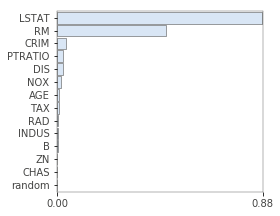

In [86]:
imp = importances(rf2, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [166]:
feature_imp_df['importance']=-1*feature_imp_df['importance']
feature_imp_df['sign']=feature_imp_df.importance>0
feature_imp_df=feature_imp_df.sort_values(by=['importance'], ascending=False)

In [167]:
%R 

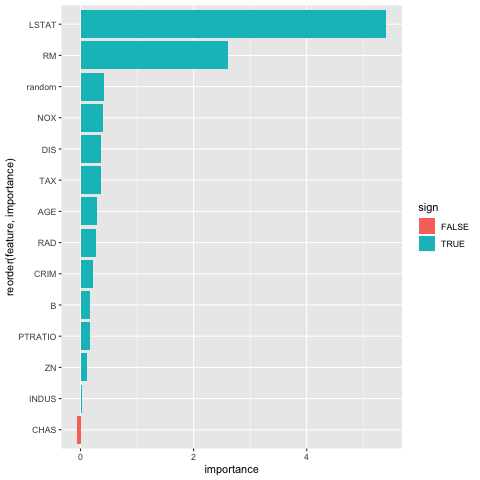

In [184]:
%%R
ggplot(data=feature_imp_df, aes(x = reorder(feature, importance), y = importance, fill = sign),
          color = "white",                           
          x.text.angle = 90,         
          ggtheme = theme_minimal()
          )+
geom_bar(stat = "identity")+ coord_flip()

In [175]:
def permutation_importances(model, X_train, y_train):
    model.fit(X_train, y_train)
    baseline = mean_squared_error(y_train, model.predict(X_train))
    imp = {}
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = mean_squared_error(y_train, model.predict(X_train))
        X_train[col] = save
        imp[col]=(baseline - m)
    return imp

In [176]:
rf_reg_perm = RandomForestRegressor(n_estimators=100, n_jobs=-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)

In [178]:
importances_perm=permutation_importances(rf_reg_perm, X_train, y_train)
importances_perm

{'CRIM': -2.17561217489531,
 'ZN': -0.01540521862791877,
 'INDUS': -0.16453028050560548,
 'CHAS': 0.0,
 'NOX': -1.0046130957406358,
 'RM': -27.85764137948267,
 'AGE': -0.9903600425905488,
 'DIS': -1.636027873463064,
 'RAD': -0.07177409262872914,
 'TAX': -0.2784303251932503,
 'PTRATIO': -0.37530123083518596,
 'B': -0.27180980904403995,
 'LSTAT': -48.626066649063716,
 'random': -0.1333888165005881}

In [179]:
feature_imp_df_perm=pd.DataFrame(importances_perm.items(), columns=['feature', 'importance'])

In [180]:
feature_imp_df_perm['importance']=-1*feature_imp_df_perm['importance']
feature_imp_df_perm['sign']=feature_imp_df_perm.importance>0
feature_imp_df_perm=feature_imp_df_perm.sort_values(by=['importance'], ascending=False)

In [181]:
%R -i feature_imp_df_perm

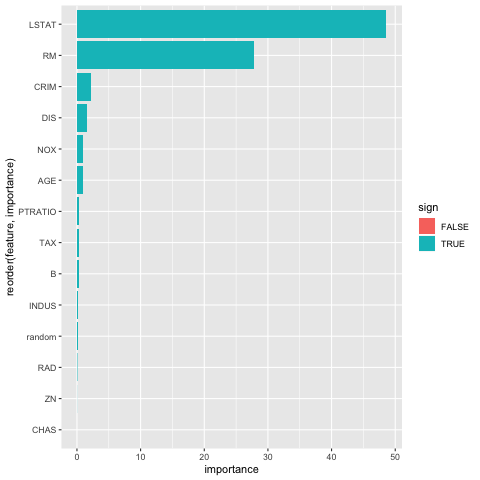

In [182]:
%%R
ggplot(data=feature_imp_df_perm, aes(x = reorder(feature, importance), y = importance, fill = sign),
          color = "white",                           
          x.text.angle = 90,         
          ggtheme = theme_minimal()
          )+
geom_bar(stat = "identity")+ coord_flip()